You now know the following

1. Generate open-loop control from a given route

2. Simulate vehicular robot motion using bicycle/ unicycle model

Imagine you want to make an utility for your co-workers to try and understand vehicle models. 
Dashboards are common way to do this.

There are several options out there : Streamlit, Voila, Observable etc

Follow this
<a href="https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e">Medium post</a> on Jupyter Dash and see how to package what you learnt today in an interactive manner

Here is a   <a href="https://stackoverflow.com/questions/53622518/launch-a-dash-app-in-a-google-colab-notebook">stackoverflow question </a> on how to run dash applications on Collab

What can you assume?
+ Fix $v,\omega$ or $v,\delta$ depending on the model (users can still pick the actual value)
+ fixed wheelbase for bicycle model

Users can choose 
+ unicycle and bicycle models
+ A pre-configured route ("S", "inverted-S", "figure-of-eight" etc)
+ 1 of 3 values for $v, \omega$ (or $\delta$) 

> **Note**: Please proceed to Initialize section throug Table of contents. The rest of this section is just demo.

Demo app from the [Medium post](https://medium.com/plotly/introducing-jupyterdash-811f1f57c02e)

In [14]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output# Load Data
df = px.data.tips()# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return px.scatter(
        df, x="total_bill", y="tip", color="size",
        color_continuous_scale=colorscale,
        render_mode="webgl", title="Tips"
    )# Run app and display result inline in the notebook
app.run_server(mode='inline')

/Users/avneesh/opt/anaconda3/envs/ap102/lib/python3.9/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



In [13]:
del app

A list of components that can be useful (code from [plotly](https://dash.plotly.com/layout) documentation). Modified for [callbacks](https://dash.plotly.com/basic-callbacks) for multiple inputs.

**Further reference for the section below**

- `plotly.express` [reference](https://plotly.com/python/plotly-express/)

In [15]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.Label('Dropdown'),
    dcc.Dropdown(
        id="ss-dropdown",
        options=[
            {'label': 'New York City', 'value': 'NYC'},
            {'label': 'Montreal', 'value': 'MTL'},
            {'label': 'San Francisco', 'value': 'SF'}
        ],
        value='MTL'
    ),

    html.Label('Multi-Select Dropdown'),
    dcc.Dropdown(
        id="ms-dropdown",
        options=[
            {'label': 'New York City', 'value': 'NYC'},
            {'label': 'Montreal', 'value': 'MTL'},
            {'label': 'San Francisco', 'value': 'SF'}
        ],
        value=['MTL', 'SF'],
        multi=True
    ),

    html.Label('Radio Items'),
    dcc.RadioItems(
        id="radio",
        options=[
            {'label': 'New York City', 'value': 'NYC'},
            {'label': 'Montreal', 'value': 'MTL'},
            {'label': 'San Francisco', 'value': 'SF'}
        ],
        value='MTL'
    ),

    html.Label('Checkboxes'),
    dcc.Checklist(
        id="checkbox",
        options=[
            {'label': 'New York City', 'value': 'NYC'},
            {'label': u'Montréal', 'value': 'MTL'},
            {'label': 'San Francisco', 'value': 'SF'}
        ],
        value=['MTL', 'SF']
    ),

    html.Label('Text Input'),
    dcc.Input(
        id="my-input",
        value='MTL', 
        type='text'
    ),

    html.Label('Slider'),
    dcc.Slider(
        id="slider",
        min=0,
        max=9,
        marks={i: 'Label {}'.format(i) if i == 1 else str(i) for i in range(1, 6)},
        value=5,
    ),
    html.Br(),
    html.Div("Output", id="my-output")
])  # , style={'columnCount': 2}

# Creating a custom callback
@app.callback(
    Output(component_id="my-output", component_property="children"),
    [
     Input(component_id='my-input', component_property='value'),
     Input(component_id='ss-dropdown', component_property='value'),
    ]
)
def debug_values(in1, in2):
    output = f"State: {in1}; {in2}"
    return output

app.run_server(mode='inline')

In [16]:
del app

## Initialize

Creating an app for the Bicycle model. We'll use a similar approach as in the bicycle notebook. You can restart runtime here (using `Ctrl + M .`)

### Setup

In [1]:
# Import everything
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
# For the modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

Define the model

In [2]:
def unicycle_model(curr_pose, v, w, dt=1.0):
    x, y, theta = curr_pose
    x_new = x + v * np.cos(theta) * dt
    y_new = y + v * np.sin(theta) * dt
    theta_new = theta + w * dt
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return newly calculated (x, y, theta)
    return x_new, y_new, theta_new

Define the Paths and a function that will give the $v$ and $\delta$ values

In [3]:
def get_open_loop_commands_sampled(route, vc=1, vc_turn = 0.2, wc=np.pi/12, 
                                   sr=0.5):
    all_w = np.array([])
    all_v = np.array([])
    ang_speed = {
        "straight": 0.0,
        "left": wc,
        "right": -wc
    }
    lin_speed = {
        "straight": vc,
        "left": vc_turn,
        "right": vc_turn
    }
    for (command, value) in route:
        if (command in ["left", "right"]):
            value = np.deg2rad(value)
        time_cmd = value / (vc if command == "straight" else wc)
        t_val = int(np.ceil(time_cmd) * sr)
        all_w = np.append(all_w, [ang_speed[command]] * t_val)
        all_v = np.append(all_v, [lin_speed[command]] * t_val)
    return all_v, all_w

Define the paths in terms of commands

- `path_S`: [("right", 90), ("straight", 5), ("left", 90), ("straight", 5), ("left", 90), ("straight", 5), ("right", 90), ("straight", 5), ("right", 90), ("straight", 5)]
- `path_8`: [("straight", 10), ("right", 90), ("straight", 5), ("right", 90), ("straight", 10), ("right", 90), ("straight", 5), ("right", 90), ("straight", 5), ("right", 90), ("straight", 5)]
- `path_inv_S`: [("right", 90), ("straight", 5), ("right", 90), ("straight", 5), ("right", 90), ("straight", 5), ("left", 90), ("straight", 5), ("left", 90), ("straight", 5)]

In [4]:
path_S = [("right", 90), ("straight", 5), ("left", 90), ("straight", 5), 
          ("left", 90), ("straight", 5), ("right", 90), ("straight", 5), 
          ("right", 90), ("straight", 5)]
path_8 = [("straight", 10), ("right", 90), ("straight", 5), ("right", 90), 
          ("straight", 10), ("right", 90), ("straight", 5), ("right", 90), 
          ("straight", 5), ("right", 90), ("straight", 5), ("right", 90)]
path_inv_S = [("right", 90), ("straight", 5), ("right", 90), ("straight", 5), 
          ("right", 90), ("straight", 5), ("left", 90), ("straight", 5), 
          ("left", 90), ("straight", 5)]

Sample test (you can test with different paths and `sr` values to see the result)

In [5]:
sr = 10
dt = 1/sr
all_v, all_w = get_open_loop_commands_sampled(path_S, sr=sr)
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(pose)
for v, w in zip(all_v, all_w):
    pose = unicycle_model(pose, v, w, dt=dt)
    robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)

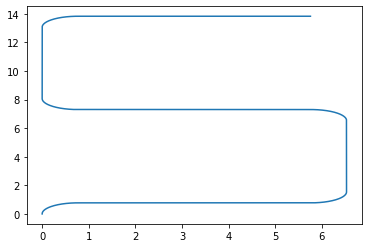

In [6]:
# Plot it
plt.figure()
plt.plot(robot_trajectory[:, 0], robot_trajectory[:, 1])


### App

Make sure you run the `Setup` section above

Now, create the app for running (this has to be in one code cell)

In [7]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.Label('Path selection'),
    dcc.Dropdown(
        id="path-dropdown",
        options=[
            {'label': 'S Curve', 'value': 'path_S'},
            {'label': 'Inverted S Curve', 'value': 'path_inv_S'},
            {'label': '8 Curve', 'value': 'path_8'}
        ],
        value='path_S'
    ),

    html.Div([
        html.Label('Inputs'),
        "Sampling Rate",
        dcc.Input(id='in-sr', value='2.0' ,type='number'),
        "V (Straight)",
        dcc.Input(id='in-vc', value='1.0', type='number'),
        "V (Turns)",
        dcc.Input(id='in-vcturn', value='0.2', type='number'),
    ]),

    dcc.Graph(id='out-path'),
    dcc.Graph(id='out-v'),
    dcc.Graph(id='out-w'),
])

@app.callback(
    [
     Output('out-path', 'figure'),
     Output('out-v', 'figure'),
     Output('out-w', 'figure')
    ],
    [
     Input('path-dropdown', 'value'),
     Input('in-sr', 'value'),
     Input('in-vc', 'value'),
     Input('in-vcturn', 'value'),
    ]
)
def ret_graph(path_dd, sr_in, vc_in, vcturn_in):
    # Get path
    path = []
    if path_dd == 'path_S':
        path = path_S
    elif path_dd == 'path_8':
        path = path_8
    elif path_dd == 'path_inv_S':
        path = path_inv_S
    # Get properties
    sr = float(sr_in)
    vc = float(vc_in)
    vc_turn = float(vcturn_in)
    # Create model
    dt = 1.0/sr
    pose = np.array([0, 0, np.pi/2])
    robot_trajectory = [pose]
    all_v, all_w = get_open_loop_commands_sampled(path, vc=vc, vc_turn=vc_turn, 
                                                  sr=sr)
    for v, w in zip(all_v, all_w):
        pose = unicycle_model(pose, v, w, dt=dt)
        robot_trajectory.append(pose)
    robot_trajectory = np.array(robot_trajectory)
    # Create graph
    robot_traj_graph = px.scatter(
        title="Robot Trajectory",
        x=robot_trajectory[:, 0],
        y=robot_trajectory[:, 1]
    )
    v_graph = px.scatter(x=np.arange(0, all_v.shape[0], 1), y=all_v, title="V", 
                         labels={'x': "Num of Sample"})
    w_graph = px.scatter(x=np.arange(0, all_w.shape[0], 1), y=all_w, title="W", 
                         labels={'x': "Num of Sample"})
    return [robot_traj_graph, v_graph, w_graph]



app.run_server(mode='inline')